In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [4]:
features_train, features_test, targets_train, targets_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)

In [5]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [6]:
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

In [7]:
LR = 0.01
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [8]:
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [9]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,24,24)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,12,12)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,8,8)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,4,4)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [10]:
#選擇優化器 Adam，loss function : CrossEntropyLoss()
model = CNN_Model()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1,1,28,28)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


In [11]:
def fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader):
    # Traning the Model
    #history-like list for store loss & acc value
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    for epoch in range(num_epochs):
        #training model & store loss & acc / epoch
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            # 1.Define variables
            train = Variable(images.view(input_shape))
            labels = Variable(labels)
            # 2.Clear gradients
            optimizer.zero_grad()
            # 3.Forward propagation
            outputs = model(train)
            # 4.Calculate softmax and cross entropy loss
            train_loss = loss_func(outputs, labels)
            # 5.Calculate gradients
            train_loss.backward()
            # 6.Update parameters
            optimizer.step()
            # 7.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 8.Total number of labels
            total_train += len(labels)
            # 9.Total correct predictions
            correct_train += (predicted == labels).float().sum()
        #10.store val_acc / epoch
        train_accuracy = 100 * correct_train / float(total_train)
        training_accuracy.append(train_accuracy)
        # 11.store loss / epoch
        training_loss.append(train_loss.data)

        #evaluate model & store loss & acc / epoch
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            # 1.Define variables
            test = Variable(images.view(input_shape))
            # 2.Forward propagation
            outputs = model(test)
            # 3.Calculate softmax and cross entropy loss
            val_loss = loss_func(outputs, labels)
            # 4.Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            # 5.Total number of labels
            total_test += len(labels)
            # 6.Total correct predictions
            correct_test += (predicted == labels).float().sum()
        #6.store val_acc / epoch
        val_accuracy = 100 * correct_test / float(total_test)
        validation_accuracy.append(val_accuracy)
        # 11.store val_loss / epoch
        validation_loss.append(val_loss.data)
        print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch+1, num_epochs, train_loss.data, train_accuracy, val_loss.data, val_accuracy))
    return training_loss, training_accuracy, validation_loss, validation_accuracy

In [12]:
training_loss, training_accuracy, validation_loss, validation_accuracy = fit_model(model, loss_func, optimizer, input_shape, num_epochs, train_loader, test_loader)

Train Epoch: 1/20 Traing_Loss: 0.10193076729774475 Traing_acc: 95.612503% Val_Loss: 0.05999629944562912 Val_accuracy: 98.125000%
Train Epoch: 2/20 Traing_Loss: 0.005367421079427004 Traing_acc: 98.270836% Val_Loss: 0.13055890798568726 Val_accuracy: 98.183334%
Train Epoch: 3/20 Traing_Loss: 0.022351978346705437 Traing_acc: 98.625000% Val_Loss: 0.014423513785004616 Val_accuracy: 98.316666%
Train Epoch: 4/20 Traing_Loss: 0.03902258723974228 Traing_acc: 98.824997% Val_Loss: 0.010706357657909393 Val_accuracy: 98.316666%
Train Epoch: 5/20 Traing_Loss: 0.032358478754758835 Traing_acc: 98.781250% Val_Loss: 0.04519297182559967 Val_accuracy: 98.308334%
Train Epoch: 6/20 Traing_Loss: 0.02341875247657299 Traing_acc: 98.837502% Val_Loss: 0.03914862871170044 Val_accuracy: 98.375000%
Train Epoch: 7/20 Traing_Loss: 0.0005584109458141029 Traing_acc: 99.006248% Val_Loss: 0.029728159308433533 Val_accuracy: 98.425003%
Train Epoch: 8/20 Traing_Loss: 0.029453182592988014 Traing_acc: 99.062500% Val_Loss: 0.07

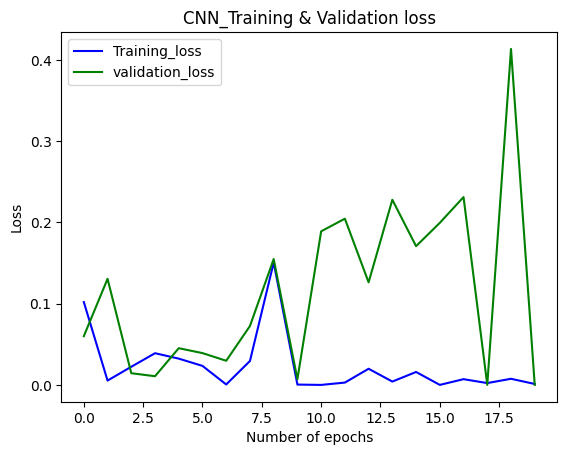

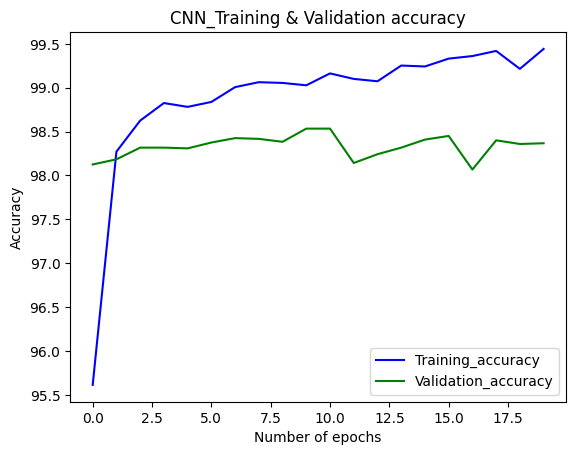

In [13]:
plt.plot(range(num_epochs), training_loss, 'b-', label='Training_loss')
plt.plot(range(num_epochs), validation_loss, 'g-', label='validation_loss')
plt.title('CNN_Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(num_epochs), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(num_epochs), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('CNN_Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()